In [1]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim

import time
import os
import PIL.Image as Image
from IPython.display import display

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
# setting root directory
data_dir = './car_data/'

# specifying values for data transformation
train_transform = transforms.Compose([transforms.Resize((400, 400)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(45),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose([transforms.Resize((400, 400)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# loading and transforming the data
train_set = torchvision.datasets.ImageFolder(root=data_dir+'train', transform = train_transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)

test_set = torchvision.datasets.ImageFolder(root=data_dir+'test', transform = test_transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True, num_workers=2)

In [ ]:
# creating a new folder to save models
# uncomment this if the folder has not yet existed
# os.mkdir('model')

In [3]:
# creating inv_norm function to plot images
def inv_norm(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    x = image.new(*image.size())    
    x[:, 0, :, :] = image[:, 0, :, :] * std[0] + mean[0]
    x[:, 1, :, :] = image[:, 1, :, :] * std[1] + mean[1]
    x[:, 2, :, :] = image[:, 2, :, :] * std[2] + mean[2]    
    return x

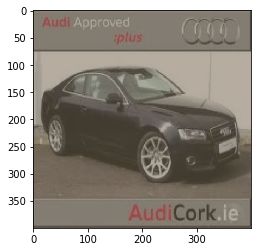

In [4]:
# plotting images from the dataset
images, labels = next(iter(testloader))
images = inv_norm(images)
images = images[0, :, :, :].numpy()
images = images.transpose([1, 2, 0])
plt.imshow(images)

In [14]:
# creating train function for training 

def train(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    
    # set the model to train mode initially
    model.train()
    
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda (device)
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward and backward propagation + optimization
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print('Epoch %s, duration: %d s, loss: %.4f, acc: %.4f' % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = evaluate(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
        
        # save model
        best_weights = model_ft.state_dict()
        ckpt = {
        'loss_history': losses,
        'acc_history': (accuracies, test_accuracies),
        'weight': best_weights
        }
        torch.save(ckpt, 'model/CV_ResNet50_pretrained.pth') # use the saved model name to laod the model for later use
        
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [15]:
# create evaluate function for validation 

def evaluate(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [16]:
# Constructing MCO (Model, Criterion, Optimizer)

# load the pretrained resnet50 model
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# replace the last fc layer with an untrained one
model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# set a scheduler to reduce learning rate on plateau
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [17]:
# initialize training
model_ft, training_losses, training_accs, test_accs = train(model_ft, criterion, optimizer, lrscheduler, n_epochs=10)

Epoch 1, duration: 102 s, loss: 4.3630, acc: 9.9387
Accuracy of the network on the test images: 21 %
Epoch 2, duration: 102 s, loss: 2.2417, acc: 42.4142
Accuracy of the network on the test images: 45 %
Epoch 3, duration: 101 s, loss: 1.3366, acc: 63.7868
Accuracy of the network on the test images: 61 %
Epoch 4, duration: 101 s, loss: 0.9168, acc: 74.9387
Accuracy of the network on the test images: 70 %
Epoch 5, duration: 103 s, loss: 0.6740, acc: 81.0784
Accuracy of the network on the test images: 71 %
Epoch 6, duration: 102 s, loss: 0.4976, acc: 85.9436
Accuracy of the network on the test images: 73 %
Epoch 7, duration: 102 s, loss: 0.2383, acc: 94.3382
Accuracy of the network on the test images: 88 %
Epoch 8, duration: 102 s, loss: 0.1666, acc: 96.2132
Accuracy of the network on the test images: 89 %
Epoch 9, duration: 102 s, loss: 0.1386, acc: 97.0588
Accuracy of the network on the test images: 89 %
Epoch 10, duration: 102 s, loss: 0.1263, acc: 97.3407
Accuracy of the network on th

In [ ]:
# Load model
# uncomment to load the saved model
# ckpt = torch.load('model/CV_ResNet50_pretrained.pth', map_location='cpu') # set the model name as specified in the train funtion
# model_ft.load_state_dict(ckpt['weight'])
# model_ft = model_ft.to(device)

In [ ]:
# run the loaded model
# note that the model should be run with a lower learning rate than initially set (< 0.01)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

# model_ft, training_losses, training_accs, test_accs = train(model_ft, criterion, optimizer, lrscheduler, n_epoch=10)